In [1]:
#Importing libraries
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('vader_lexicon')
from bs4 import BeautifulSoup
from sec_api import ExtractorApi
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim import corpora, models
from gensim.models import LdaModel
import gensim
import spacy
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tabulate import tabulate
from gensim.models import Phrases

In [2]:
#Get an api key from https://sec-api.io/
API_KEY = '05d42b2c37c8616469fd187bd27e1b9ebba8a0dd85736cdf38cb395ff3377873'
extractorApi = ExtractorApi(API_KEY)

In [99]:
#URL of BlackRock's 2023 and 2022 10-K filings
url_FY23 = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1364742/000095017024019271/blk-20231231.htm"
url_FY22 = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001364742/000095017023004343/blk-20221231.htm"

#Extracting html sections (Item 1, Item 1A, Item 7, and Item 7A) from 2023 10-K filings
item_1_FY23 = extractorApi.get_section(url_FY23, '1', 'html')
item_1A_FY23 = extractorApi.get_section(url_FY23, '1A', 'html')
item_7_FY23 = extractorApi.get_section(url_FY23, '7', 'html')
item_7A_FY23 = extractorApi.get_section(url_FY23, '7A', 'html')

#Extracting html sections (Item 1, Item 1A, Item 7, and Item 7A) from 2022 10-K filings
item_1_FY22 = extractorApi.get_section(url_FY22, '1', 'html')
item_1A_FY22 = extractorApi.get_section(url_FY22, '1A', 'html')
item_7_FY22 = extractorApi.get_section(url_FY22, '7', 'html')
item_7A_FY22 = extractorApi.get_section(url_FY22, '7A', 'html')

#Printing item_1_FY23 html as a sample to demonstrate output
print(item_1_FY23[:1000])

<span style="color:#000000;white-space:pre-wrap;font-size:14pt;font-family:Arial;min-width:fit-content;">Item 1. B</span><span style="color:#000000;white-space:pre-wrap;font-size:14pt;font-family:Arial;min-width:fit-content;">usiness</span><span style="color:#000000;white-space:pre-wrap;font-size:14pt;font-family:Arial;min-width:fit-content;"> </span></p> <p style="font-size:10pt;margin-top:8pt;font-family:Times New Roman;margin-bottom:4pt;text-align:justify;"><span style="text-transform:uppercase;color:#000000;white-space:pre-wrap;font-weight:bold;font-size:8.5pt;font-family:Arial;min-width:fit-content;">Overview</span><span style="text-transform:uppercase;color:#000000;white-space:pre-wrap;font-weight:bold;font-size:8.5pt;font-family:Arial;min-width:fit-content;"> </span></p> <p style="font-size:10pt;margin-top:0;font-family:Times New Roman;margin-bottom:4pt;text-align:justify;"><span style="color:#000000;white-space:pre-wrap;font-size:8.5pt;font-family:Arial;min-width:fit-content;">

In [246]:
#Creating a dictionary containing all 2022-2023 items
FY22FY23_items = {"item_1_FY23": item_1_FY23,
                  "item_1A_FY23": item_1A_FY23,
                  "item_7_FY23": item_7_FY23,
                  "item_7A_FY23": item_7A_FY23,
                  "item_1_FY22": item_1_FY22,
                  "item_1A_FY22": item_1A_FY22,
                  "item_7_FY22": item_7_FY22,
                  "item_7A_FY22": item_7A_FY22}

In [247]:
#Creating an empty dataframe to store the # of words and sentences, as well as the average lengths of words and sentences
summary_stats = pd.DataFrame(columns = ['# of Words','# of Sentences','Avg Word Length','Avg Sentence Length'])

#Creating empty dictionaries to store the tables, headers, and cleaned text (without html tags, stop words, etc)
tables_dict = {}
headers_dict = {}
cleaned_dict = {}


stop_words = set(stopwords.words('english'))
    
for name, html in FY22FY23_items.items():
    
    soup = BeautifulSoup(html, 'html.parser')
    
    #Finding all table elements
    tables = soup.find_all('table')
    #Storing the tables for the current section in the dictionary
    tables_dict[name] = [str(table) for table in tables]
    #Removing all table elements
    for table in tables:
        table.decompose()
        
    headers = []
    #Looking for <span> or <div> tags that have a style attribute containing 'font-weight:bold' to find headers
    if name == 'item_7A_FY23' or name == 'item_7A_FY22':
        for tag in soup.find_all(['span', 'div'], style=lambda value: value and 'font-weight:bold' in value):# and 'text-transform:uppercase' in value):#and 'font-weight:700' in value):
            headers.append(tag.get_text(strip=True))
    else:
        for tag in soup.find_all(['span', 'div'], style=lambda value: value and 'font-weight:bold' in value and 'text-transform:uppercase' in value):#and 'font-weight:700' in value):
            headers.append(tag.get_text(strip=True))
        
    #Storing the headers for the current section in the dictionary
    headers_dict[name] = headers

    #Extracting text without tables, using a space as a separator for each tag's text
    html = soup.get_text(separator = ' ', strip = True)
    #Replacing multiple spaces with a single space
    html = re.sub(r'\s+', ' ', html)
    #Removing special characters, Keeping word characters, whitespace, and sentence-ending punctuatio
    html = re.sub(r'[^\w\s\.\!\?]', '', html)
    
    #Segmenting text into sentences
    sentences = sent_tokenize(html)
    #Lowercasing, then removing stop words from sentences
    cleaned_sentences = []
    for sentence in sentences:
        words = sentence.split()
        cleaned_words = [word.lower() for word in words if word.lower() not in stop_words]
        cleaned_sentence = ' '.join(cleaned_words)
        cleaned_sentences.append(cleaned_sentence)
    #Storing the sentences for the current section in the dictionary    
    cleaned_dict[name] = cleaned_sentences
        
    #Number of sentences
    num_sentences = len(cleaned_sentences)
    #Flattening the list of cleaned sentences to a list of words
    all_words = [word for sentence in cleaned_sentences for word in sentence.split()]
    #Number of sords
    num_words = len(all_words)
    #Average sord length
    avg_word_length = sum(len(word) for word in all_words) / num_words if num_words > 0 else 0
    #Average sentence length (in terms of words)
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0
    
    summary_stats.loc[name, '# of Words'] = num_words
    summary_stats.loc[name, '# of Sentences'] = num_sentences
    summary_stats.loc[name, 'Avg Word Length'] = avg_word_length
    summary_stats.loc[name, 'Avg Sentence Length'] = avg_sentence_length
    
    #Removing special characters, keep only words and spaces
    #html = re.sub(r'[^\w\s]', '', html)

In [248]:
#Calculating the avg length of words and sentences for 2022 and 2023
w_avg_23 = sum(summary_stats[:4]['# of Words'] * summary_stats[:4]['Avg Word Length']) / sum(summary_stats[:4]['# of Words'])
s_avg_23 = sum(summary_stats[:4]['# of Sentences'] * summary_stats[:4]['Avg Sentence Length']) / sum(summary_stats[:4]['# of Sentences'])
w_avg_22 = sum(summary_stats[4:8]['# of Words'] * summary_stats[4:8]['Avg Word Length']) / sum(summary_stats[4:8]['# of Words'])
s_avg_22 = sum(summary_stats[4:8]['# of Sentences'] * summary_stats[4:8]['Avg Sentence Length']) / sum(summary_stats[4:8]['# of Sentences'])

#Calculating the # of words and sentences for 2022 and 2023
summary_stats.loc['FY23_Total'] = summary_stats.iloc[:4].sum()
summary_stats.loc['FY22_Total'] = summary_stats.iloc[4:8].sum()

#Replacing the avg length of words and sentences for 2022 and 2023
summary_stats.loc['FY23_Total', 'Avg Word Length'] = w_avg_23
summary_stats.loc['FY23_Total', 'Avg Sentence Length'] = s_avg_23
summary_stats.loc[ 'FY22_Total', 'Avg Word Length'] = w_avg_22
summary_stats.loc[ 'FY22_Total', 'Avg Sentence Length'] = s_avg_22

#Printng the dataframe
print(tabulate(summary_stats, headers='keys', tablefmt='pretty', floatfmt=".2f"))

+--------------+------------+----------------+-------------------+---------------------+
|              | # of Words | # of Sentences |  Avg Word Length  | Avg Sentence Length |
+--------------+------------+----------------+-------------------+---------------------+
| item_1_FY23  |    9701    |      530       | 7.363158437274508 |  18.30377358490566  |
| item_1A_FY23 |    9787    |      436       | 7.564728721773782 |  22.44724770642202  |
| item_7_FY23  |    9171    |      498       | 7.323955948097263 |  18.41566265060241  |
| item_7A_FY23 |    503     |       29       | 7.20675944333996  | 17.344827586206897  |
| item_1_FY22  |   10213    |      554       | 7.351316948986586 | 18.435018050541515  |
| item_1A_FY22 |    9494    |      429       | 7.541710554034127 |  22.13053613053613  |
| item_7_FY22  |    8606    |      474       | 7.283987915407855 | 18.156118143459917  |
| item_7A_FY22 |    485     |       32       | 7.216494845360825 |      15.15625       |
|  FY23_Total  |   29

In [249]:
#Initializing VADER for sentiment analysis
sia = SentimentIntensityAnalyzer()

#Initializing variables to hold concatenated text of 2023 and 2022
text_2023 = ""
text_2022 = ""

#List to hold all keys to ensure the order is maintained
keys = list(cleaned_dict.keys())

#Loop through each section in the dictionary to analyze sentiment
for item, content in cleaned_dict.items():
    #Join list of strings into a single string if necessary
    text = " ".join(content)

    #Use TextBlob to determine sentiment of the section's text
    blob = TextBlob(text)
    blob_sentiment = blob.sentiment
    
    #Use VADER to determine sentiment of the section's text
    vader_sentiment = sia.polarity_scores(text)
    
    #Print out the section name and its sentiment analysis results
    print(f"Section: {item}")
    print(f"TextBlob Sentiment: {blob_sentiment}")
    print(f"VADER Sentiment: {vader_sentiment}")
    print("\n")
    
    #Concatenate text for group sentiment analysis
    if item in keys[:4]:
        text_2023 += " " + text
    else:
        text_2022 += " " + text

#Performing group sentiment analysis on 2023
blob_2023 = TextBlob(text_2023)
vader_2023 = sia.polarity_scores(text_2023)

print("Sentiment Analysis for the Entire Year of 2023:")
print(f"TextBlob Sentiment: {blob_2023.sentiment}")
print(f"VADER Sentiment: {vader_2023}")
print("\n")

# Perform group sentiment analysis on 2022
blob_2022 = TextBlob(text_2022)
vader_2022 = sia.polarity_scores(text_2022)

print("Sentiment Analysis for the Entire Year of 2022:")
print(f"TextBlob Sentiment: {blob_2022.sentiment}")
print(f"VADER Sentiment: {vader_2022}")

Section: item_1_FY23
TextBlob Sentiment: Sentiment(polarity=0.0525149599302142, subjectivity=0.32732297520433057)
VADER Sentiment: {'neg': 0.034, 'neu': 0.811, 'pos': 0.155, 'compound': 1.0}


Section: item_1A_FY23
TextBlob Sentiment: Sentiment(polarity=0.04799630577755589, subjectivity=0.38804949937882566)
VADER Sentiment: {'neg': 0.12, 'neu': 0.73, 'pos': 0.15, 'compound': 0.9997}


Section: item_7_FY23
TextBlob Sentiment: Sentiment(polarity=0.063776229078777, subjectivity=0.35633192709625827)
VADER Sentiment: {'neg': 0.04, 'neu': 0.781, 'pos': 0.18, 'compound': 1.0}


Section: item_7A_FY23
TextBlob Sentiment: Sentiment(polarity=0.049192897497982245, subjectivity=0.3579701372074253)
VADER Sentiment: {'neg': 0.09, 'neu': 0.733, 'pos': 0.176, 'compound': 0.9939}


Section: item_1_FY22
TextBlob Sentiment: Sentiment(polarity=0.04654577012135157, subjectivity=0.3170715048219516)
VADER Sentiment: {'neg': 0.034, 'neu': 0.815, 'pos': 0.151, 'compound': 1.0}


Section: item_1A_FY22
TextBlob S

In [250]:
#Comparing headers for each of Item 1, Item 7, and Item 7A between 2022 and 2023
for i in range(0,4):
    #Selecting the same item from 2022 and 2023 for comparison, based on their positions in the headers_dict
    items_list = list(FY22FY23_items.keys())
    item2023, item2022 = items_list[i], items_list[i + 4]
    
    #Extract and store detailed risk explanations from Item 1A into a separate dictionary for further analysis
    if i == 1:
        risk_explanation_dict = {}
        for item in (item2023, item2022):
            #Filter out None values, then separate based on length
            long_strings = [s for s in headers_dict[item] if s is not None and len(s) > 100]
            short_strings = [s for s in headers_dict[item] if s is not None and len(s) <= 100]

            risk_explanation_dict[item] = long_strings
            #Updating the original dictionary to keep only short strings
            headers_dict[item] = short_strings
    
    headers_dict[item2023] = [s for s in headers_dict[item2023] if s is not None and len(s) > 4]
    headers_dict[item2022] = [s for s in headers_dict[item2022] if s is not None and len(s) > 4]
    
    #Extending the list of headers for the year with fewer headers by adding None values to match the length of the other year
    max_length = max(len(headers_dict[item2023]), len(headers_dict[item2022]))
    
    #Extending the length of shorter item to the length of longer item with None values
    for j in (item2023,item2022):
        length_diff = max_length - len(headers_dict[j])
        if length_diff > 0:
            headers_dict[j].extend([None] * length_diff)

    #Creating a DataFrame for side-by-side comparison of headers for the current item across 2022 and 2023
    h_dict = {item2023 : headers_dict[item2023], item2022 : headers_dict[item2022]}
    h_df = pd.DataFrame(h_dict)
    h_df.drop_duplicates(inplace = True)

    #Printng the dataframe
    print(tabulate(h_df, headers='keys', tablefmt='pretty'))
    
    #Identifying and printing headers unique to each year for the current item
    unique_to_item2023 = h_df[~h_df[item2023].isin(h_df[item2022])][item2023].tolist()
    unique_to_item2022 = h_df[~h_df[item2022].isin(h_df[item2023])][item2022].tolist()
    print(f'Headers in {item2023} that are not in {item2022}:')
    print(unique_to_item2023)
    print(f'Headers in {item2022} that are not in {item2023}:')
    print(unique_to_item2022)

+----+----------------------------------------------+----------------------------------------------+
|    |                 item_1_FY23                  |                 item_1_FY22                  |
+----+----------------------------------------------+----------------------------------------------+
| 0  |                   Overview                   |                   Overview                   |
| 1  |             Financial Highlights             |             Financial Highlights             |
| 2  |           Assets Under Management            |           Assets Under Management            |
| 3  |                 Client Type                  |                 Client Type                  |
| 4  |         Client Type and Product Type         |         Client Type and Product Type         |
| 5  |                Client Region                 |                Client Region                 |
| 6  |            Investment Performance            |            Investment Performance    

In [251]:
#Printing the explanation of risk headers
for key, value in risk_explanation_dict.items():
    print(f'{key} risk explanations' + ":")
    for string in value:
        print(string)
    print()

item_1A_FY23 risk explanations:

item_1A_FY22 risk explanations:



In [252]:
#Loading the spaCy model
nlp = spacy.load('en_core_web_sm')
#Creating a dictionary to store lemmatized sentences for each item
lemmatized_dict = {}

for name, cleaned_sentences in cleaned_dict.items():
    #Creating a list to store lemmatized sentences of the item
    lemmatized_sentences = []
    #Lemmatizing the sentences and join the lemmatized tokens to form complete sentences
    for sentence in cleaned_sentences:
        doc = nlp(sentence)
        lemmatized_sentences.append(' '.join([token.lemma_ for token in doc]))
    lemmatized_dict[name] = lemmatized_sentences

In [253]:
#Printing lemmatized_dict['item_1_FY23'] as a sample to demonstrate output
lemmatized_dict['item_1_FY23']

['item 1 .',
 'b usiness overview blackrock inc . together subsidiary unless context otherwise indicate blackrock company lead publicly trade investment management firm 10.0 trillion asset management aum december 31 2023 .',
 'approximately 19800 employee 30 country serve client 100 country across globe blackrock provide broad range investment management technology service institutional retail client worldwide .',
 'blackrock diverse platform alphaseeke active index cash management investment strategy across asset class enable company offer choice tailor investment asset allocation solution client .',
 'product offering include single multiasset portfolio invest equity fix income alternative money market instrument .',
 'product offer directly intermediarie variety vehicle include openend closedend mutual fund ishares blackrock exchangetraded fund etfs separate account collective trust fund pool investment vehicle .',
 'blackrock also offer technology service include investment risk ma

In [254]:
#Convert lemmatized sentences from each section into lists of words and aggregate into a list of documents
def process_lemmatized_texts(keys):
    lemmatized_texts = []
    for key in keys:
        sentences = lemmatized_dict[key]
        lemmatized_words = [word for sentence in sentences for word in sentence.split()]
        lemmatized_texts.append(lemmatized_words)
    bigram = Phrases(lemmatized_texts, min_count = 5, threshold = 100)###
    trigram = Phrases(bigram[lemmatized_texts], threshold=100)###
    texts_with_bigrams_trigrams = [trigram[bigram[text]] for text in lemmatized_texts]###
    # Remove any empty documents
    texts_with_bigrams_trigrams = [doc for doc in texts_with_bigrams_trigrams if doc]###
    #Remove any empty documents
    ###lemmatized_texts = [doc for doc in lemmatized_texts if doc]
    return texts_with_bigrams_trigrams###lemmatized_texts

#Function to create LDA model and print topics
def create_lda_model(lemmatized_texts):
    #Create a dictionary representation of the documents
    dictionary = corpora.Dictionary(lemmatized_texts)
    #Filter out words that occur in less than 2 documents or more than 80% of the documents
    dictionary.filter_extremes(no_below = 3, no_above = 0.8)
    #Create a corpus from the dictionary and the list of texts
    corpus = [dictionary.doc2bow(text) for text in lemmatized_texts]
    #Create an LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=random_state)
    for idx, topic in lda_model.print_topics(-1, num_words = 7):
        print('Topic: {} \nWords: {}'.format(idx, topic))

# Splitting the keys of lemmatized_dict
FY23_keys = list(lemmatized_dict.keys())[:4]
FY22_keys = list(lemmatized_dict.keys())[4:]

#Set training parameters
num_topics = 3
passes = 20
random_state = 77

#Process and create LDA model for 2023
print("Topics for 2023:")
lemmatized_texts_FY23 = process_lemmatized_texts(FY23_keys)
create_lda_model(lemmatized_texts_FY23)

#Process and create LDA model for 2022
print("\nTopics for 2022:")
lemmatized_texts_FY22 = process_lemmatized_texts(FY22_keys)
create_lda_model(lemmatized_texts_FY22)

Topics for 2023:
Topic: 0 
Words: 0.021*"client" + 0.021*"regulation" + 0.013*"service" + 0.013*"uk" + 0.012*"employee" + 0.012*"strategy" + 0.010*"also"
Topic: 1 
Words: 0.027*"income" + 0.023*"expense" + 0.022*"tax" + 0.019*"million" + 0.017*"client" + 0.016*"revenue" + 0.015*"service"
Topic: 2 
Words: 0.053*"may" + 0.025*"client" + 0.018*"increase" + 0.014*"regulation" + 0.012*"new" + 0.012*"failure" + 0.011*"technology"

Topics for 2022:
Topic: 0 
Words: 0.021*"client" + 0.020*"regulation" + 0.011*"uk" + 0.011*"employee" + 0.011*"service" + 0.011*"requirement" + 0.010*"strategy"
Topic: 1 
Words: 0.025*"client" + 0.016*"regulation" + 0.013*"new" + 0.013*"failure" + 0.011*"service" + 0.010*"technology" + 0.009*"operational"
Topic: 2 
Words: 0.028*"income" + 0.026*"tax" + 0.023*"expense" + 0.018*"revenue" + 0.017*"client" + 0.015*"service" + 0.015*"amount"


Word Cloud of item_1_FY23


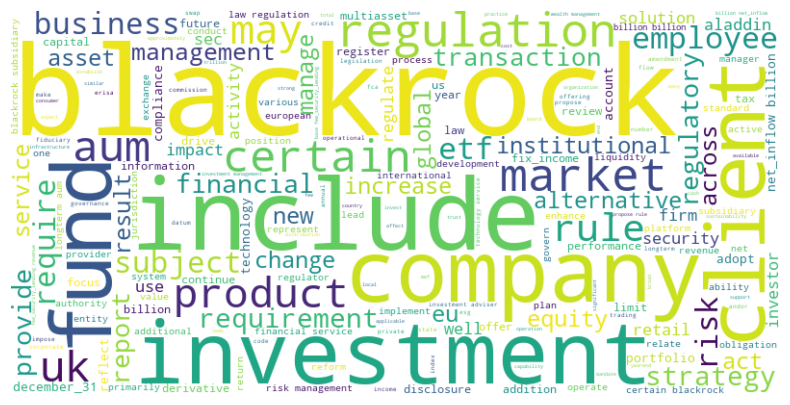

Word Cloud of item_1A_FY23


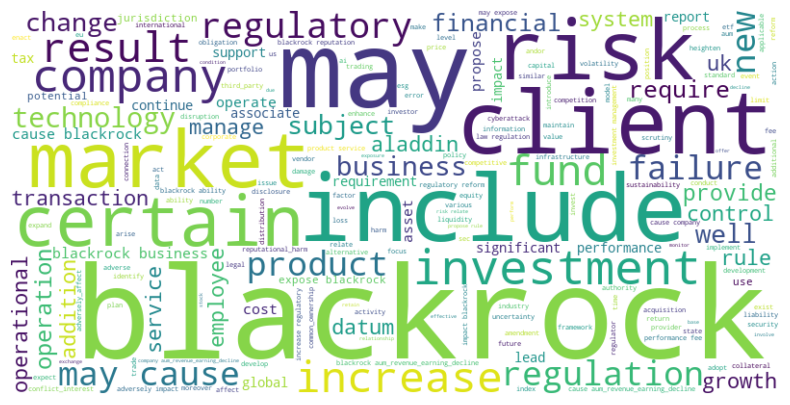

Word Cloud of item_7_FY23


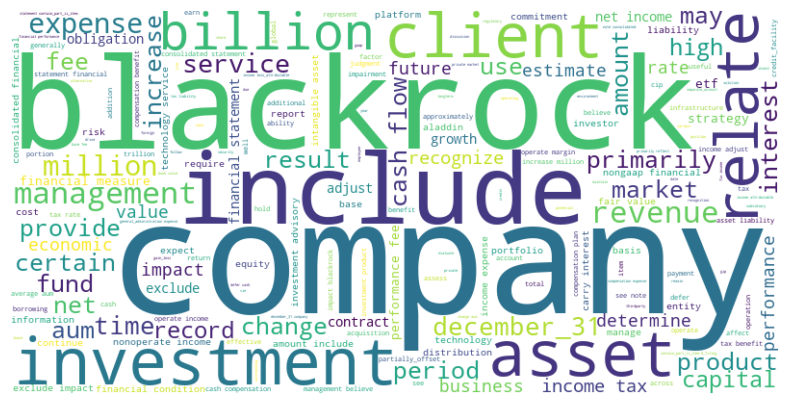

Word Cloud of item_7A_FY23


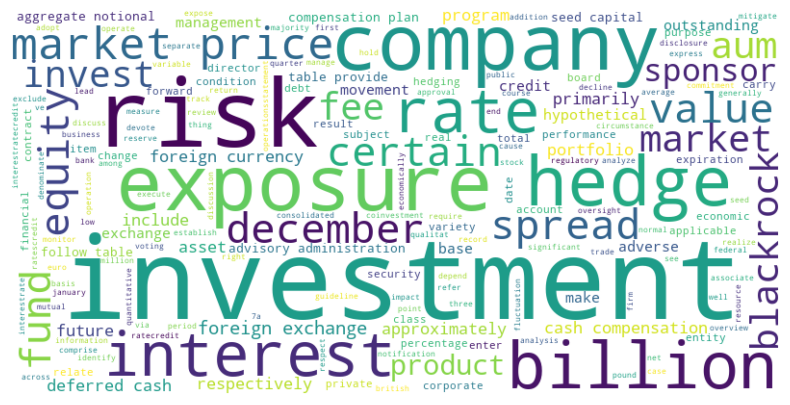

Word Cloud of item_1_FY22


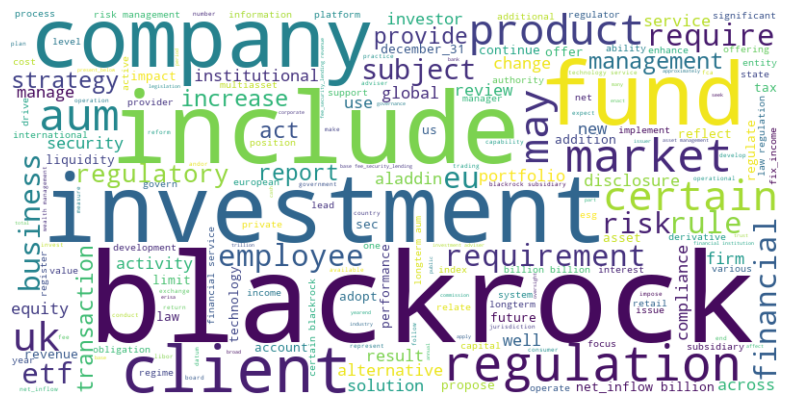

Word Cloud of item_1A_FY22


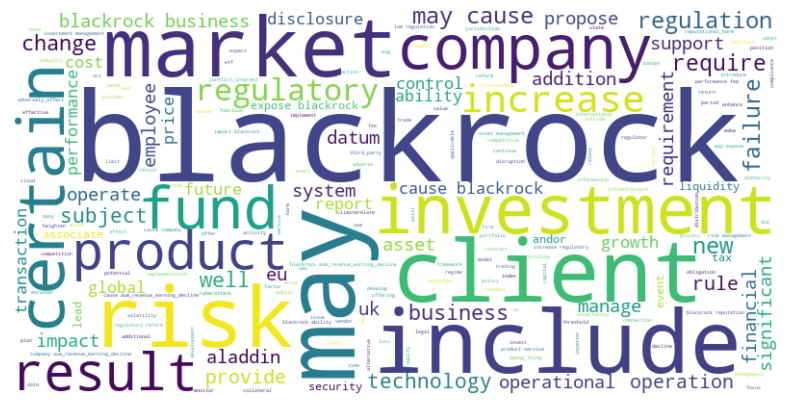

Word Cloud of item_7_FY22


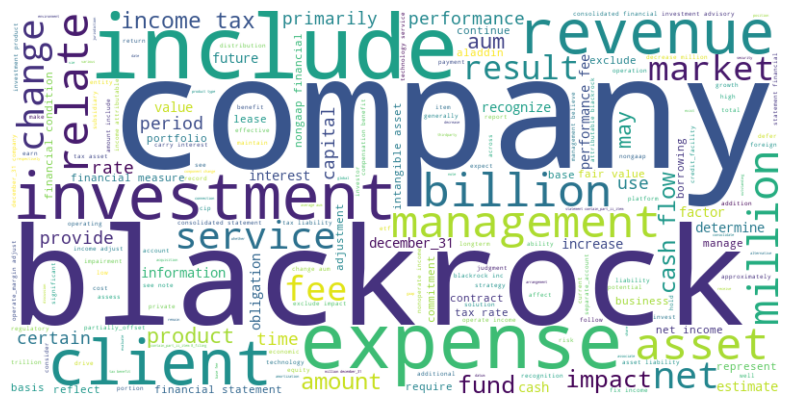

Word Cloud of item_7A_FY22


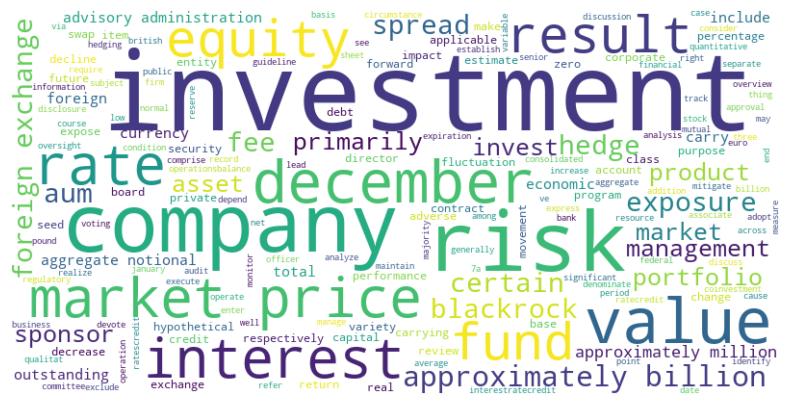

In [255]:
def get_bigrams_trigrams(texts):
    bigram_phrases = Phrases(texts, min_count=5, threshold=100)  # Adjust parameters as needed
    trigram_phrases = Phrases(bigram_phrases[texts], threshold=100)

    # Apply the models to get texts with bigrams and trigrams
    texts_with_phrases = [trigram_phrases[bigram_phrases[text]] for text in texts]
    return texts_with_phrases

#Plotting the word cloud for each item
for name, lemmatized_sentences in lemmatized_dict.items():
    lemmatized_words_lists = [sentence.split() for sentence in lemmatized_sentences]
    # Generate bigrams and trigrams
    lemmatized_texts_with_phrases = get_bigrams_trigrams(lemmatized_words_lists)   
    # Flatten the list of lists into a single list and join into a string, replacing spaces in bigrams/trigrams with underscores
    all_words = ['_'.join(word.split()) for text in lemmatized_texts_with_phrases for word in text]

    #Joining the list of lemmatized sentences into a single string
    lemmatized_sentences = ' '.join(all_words)

    #Creating a WordCloud object with desired configurations
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(lemmatized_sentences)
    #Displaying the generated word cloud
    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')  # Hide the axes
    #plt.title(f'Word Cloud of {name}', fontsize = 20, color = 'blue')
    print(f'Word Cloud of {name}')
    plt.show()

In [256]:
#Creading a dictionary to store named entities by category
ner_dict = {}

for name, cleaned_sentences in cleaned_dict.items():
    #Creating a dictionary to hold sets of unique entities for each typee
    entities_by_type = {}
    for sentence in cleaned_sentences:
        doc = nlp(sentence)
        for ent in doc.ents:
            #If the entity type is not yet in the dictionary, initialize it with an empty set
            if ent.label_ not in entities_by_type:
                entities_by_type[ent.label_] = set()
            #Add the unique entity text to the set corresponding to its type
            entities_by_type[ent.label_].add(ent.text)

    #Converting sets to lists for consistent and easier handling in later processes
    for ent_type in entities_by_type:
        entities_by_type[ent_type] = list(entities_by_type[ent_type])

    ner_dict[name] = entities_by_type

#Pringting all named entities in item_1_FY23 as an example to demonstrate the output
print(ner_dict['item_1_FY23'])

{'CARDINAL': ['1.5 trillion', '9', '13', '3 billion', '30', '2019', '29', 'approximately half', '2', '17', '33', '1 billion', '65 billion', '7 billion', '31', '2023', '15', '11', '8k', '28', '5.3 trillion', '12', '5 billion', 'approximately 8', '2024', '10.0 trillion', 'approximately 40', '47', 'approximately 75', '63', '53', '8', '46 billion', '23', '90', 'seven', '19', '19 billion', '23 billion', '21', 'five', '2023 half', '79 billion', '84 billion', '55 billion', '4', '11 billion', 'two', '17 billion', '2 billion', '65', 'six', '13 billion', '58', '3', '63 billion', '2 one', '18', '38', 'three', '6', '67', '16', '85', '41.3 billion', '31 billion', '87 billion', '4 billion', '25', '26', '9 billion', '81', '25 billion', '5', '59 billion', 'one', '103 billion', '69', '10 billion', '1', '86 billion', '55', 'approximately 19800', '10', '6 billion', '1934', '2a7', '100', '7'], 'MONEY': ['2023 2.6 trillion', '112 billion 32 billion', '10.0 trillion', '3.0 trillion', '83 billion 60 billion 

In [257]:
#Function to split incorrectly combined 'LOC' entities into separate, correct entities
#Checking for specific combined entities and splitting them into their component parts
def split_combined_entities(entity):
    if 'middle east asia' in entity.lower():
        return ['middle east', 'asia']
    if 'north america south america' in entity.lower():
        return ['north america', 'south america']
    elif 'jersey luxembourg' in entity.lower():
        return ['luxembourg']
    elif 'taiwan korea' in entity.lower():
        return ['taiwan', 'korea']
    elif 'chile dominican republic' in entity.lower():
        return ['chile', 'dominican republic']
    elif 'africa australia' in entity.lower():
        return ['africa', 'australia']
    else:
        return [entity]

#Post-processing step to correct 'LOC' entities for each key in ner_dict
#Filtering out invalid entities and splitting combined entities into their correct forms
for name, entities_by_type in ner_dict.items():
    if 'LOC' in entities_by_type:
        corrected_locs = []
        for loc_entity in entities_by_type['LOC']:
            #Filtering out the invalid 'LOC' entity 'west street'
            if 'australia' in loc_entity.lower():
                continue
            #Splitting combined entities into separate, correct entities
            corrected_locs.extend(split_combined_entities(loc_entity))
        #Updating the 'LOC' entities for the current key, ensuring all entities are unique
        ner_dict[name]['LOC'] = list(set(corrected_locs))

    if 'GPE' in entities_by_type:
        corrected_locs = []
        for loc_entity in entities_by_type['GPE']:
            #Filtering out the invalid 'GPE' entities 'u.s. bank', 'u.k. gdpr', and 'xxii'
            if 'fcas' in loc_entity.lower():
                continue
            if 'us states' in loc_entity.lower():
                continue
            if 'aegon' in loc_entity.lower():
                continue
            if 'united kingdom review retained eu' in loc_entity.lower():
                continue
            if 'eu' in loc_entity.lower():
                continue

            #Splitting combined entities into separate, correct entities
            corrected_locs.extend(split_combined_entities(loc_entity))

        #Updating the 'LOC' entities for the current key, ensuring all entities are unique
        ner_dict[name]['GPE'] = list(set(corrected_locs))

#Pringting all named entities in item_1_FY23 as an example to demonstrate the output
print(ner_dict['item_1_FY23'])

{'CARDINAL': ['1.5 trillion', '9', '13', '3 billion', '30', '2019', '29', 'approximately half', '2', '17', '33', '1 billion', '65 billion', '7 billion', '31', '2023', '15', '11', '8k', '28', '5.3 trillion', '12', '5 billion', 'approximately 8', '2024', '10.0 trillion', 'approximately 40', '47', 'approximately 75', '63', '53', '8', '46 billion', '23', '90', 'seven', '19', '19 billion', '23 billion', '21', 'five', '2023 half', '79 billion', '84 billion', '55 billion', '4', '11 billion', 'two', '17 billion', '2 billion', '65', 'six', '13 billion', '58', '3', '63 billion', '2 one', '18', '38', 'three', '6', '67', '16', '85', '41.3 billion', '31 billion', '87 billion', '4 billion', '25', '26', '9 billion', '81', '25 billion', '5', '59 billion', 'one', '103 billion', '69', '10 billion', '1', '86 billion', '55', 'approximately 19800', '10', '6 billion', '1934', '2a7', '100', '7'], 'MONEY': ['2023 2.6 trillion', '112 billion 32 billion', '10.0 trillion', '3.0 trillion', '83 billion 60 billion 

In [258]:
#Iterating over each key in ner_dict to access each sub-dictionary
for key, entity_dict in ner_dict.items():
    #Iterating over each entity type in the sub-dictionary
    for entity_type, entities in entity_dict.items():
        #Removing duplicate entities and updating the sub-dictionary
        entity_dict[entity_type] = list({entity for entity in entities})
        
#Iterating over each key in ner_dict
for key, entity_dict in ner_dict.items():
    #Checking if 'GPE' and 'LOC' keys exists in the sub-dictionary
    for ent in ['GPE','LOC']:
        if ent in entity_dict:
            print(f"{ent} entities for {key}: {entity_dict[ent]}")
        else:
            print(f"No {ent} entities found for {key}.")

GPE entities for item_1_FY23: ['south korea', 'luxembourg', 'germany', 'hong kong', 'switzerland', 'singapore', 'new york', 'saudi arabia', 'india', 'us', 'canada', 'dubai', 'france', 'dominican republic', 'japan', 'brazil', 'australia', 'netherlands', 'california', 'taiwan', 'new zealand', 'china', 'united kingdom', 'united states', 'korea', 'chile', 'uk']
LOC entities for item_1_FY23: ['europe', 'south america', 'middle east', 'asia', 'north america']
GPE entities for item_1A_FY23: ['atlanta', 'california', 'hong kong', 'china', 'singapore', 'united kingdom', 'san francisco', 'london', 'japan', 'india', 'uk', 'us', 'belgrade']
No LOC entities found for item_1A_FY23.
GPE entities for item_7_FY23: ['germany', 'uk', 'new york']
No LOC entities found for item_7_FY23.
No GPE entities found for item_7A_FY23.
No LOC entities found for item_7A_FY23.
GPE entities for item_1_FY22: ['south korea', 'luxembourg', 'germany', 'hong kong', 'switzerland', 'singapore', 'new york', 'london', 'saudi ara

In [259]:
#Initializing a list to hold refined tables
table_list = []
tbl_num = 0

for name, tables in tables_dict.items():
    #Iterating over all discovered tables
    for table in tables:
        #Converting each table to a DataFrame for processing
        tbl = pd.read_html(str(table))[0]

        #Removing columns that only contain "$" or "%", are entirely NaN, or are completely empty
        tbl = tbl.replace({"%": None})
        columns_to_drop = []
        #Iterate over each column in the DataFrame
        for col in tbl.columns:
            #Check if any cell in the column contains "$"
            if tbl[col].apply(lambda x: isinstance(x, str) and '$' in x).any():
                columns_to_drop.append(col)
        tbl.drop(columns = columns_to_drop, inplace = True)
        tbl = tbl.dropna(axis = 1, how ='all')
        tbl = tbl.loc[:, (tbl != '').any(axis = 0)]
        #Dropping columns where all values are the same (excluding NaN)
        tbl = tbl.loc[:, tbl.nunique(dropna = True) > 1]
        
        #Transpose the table, remove duplicate rows, and transpose back to original orientation
        tbl = tbl.T.drop_duplicates().T
        #Dropping rows where all values are NaN
        tbl = tbl.dropna(how = 'all')
        #Reseting the row indices for clean sequencing
        tbl.reset_index(drop = True, inplace = True)
        
        tbl_num += 1
        if tbl_num <= 3:
            tbl = tbl.drop(tbl.index[0])
        
        #Set the first row as the header
        tbl.columns = tbl.iloc[0]
        #Drop the first row that it's been set as the header
        tbl = tbl.drop(tbl.index[0])
        
        tbl.fillna("", inplace=True)
        
        #Add the refined table to the list
        table_list.append(tbl)
    
    #Printing each refined table using tabulate for improved readability
    for tbl in table_list:
         print(tabulate(tbl, headers='keys', tablefmt='pretty'))

+---+--------------------------------------------+---------+---------+---------+---------+---------+
|   |                   GAAP:                    | 2023.0  | 2022.0  | 2021.0  | 2020.0  | 2019.0  |
+---+--------------------------------------------+---------+---------+---------+---------+---------+
| 2 |               Total revenue                | 17859.0 | 17873.0 | 19374.0 | 16205.0 | 14539.0 |
| 3 |              Operating income              | 6275.0  | 6385.0  | 7450.0  | 5695.0  | 5551.0  |
| 4 |              Operating margin              |  35.1   |  35.7   |  38.5   |  35.1   |  38.2   |
| 5 |      Nonoperating income (expense)(1)      |  706.0  |  89.0   |  419.0  |  475.0  |  186.0  |
| 6 | Net income attributable to BlackRock, Inc. | 5502.0  | 5178.0  | 5901.0  | 4932.0  | 4476.0  |
| 7 |     Diluted earnings per common share      |  36.51  |  33.97  |  38.22  |  31.85  |  28.43  |
+---+--------------------------------------------+---------+---------+---------+---------+-

+---+--------------------------------------------+---------+---------+---------+---------+---------+
|   |                   GAAP:                    | 2023.0  | 2022.0  | 2021.0  | 2020.0  | 2019.0  |
+---+--------------------------------------------+---------+---------+---------+---------+---------+
| 2 |               Total revenue                | 17859.0 | 17873.0 | 19374.0 | 16205.0 | 14539.0 |
| 3 |              Operating income              | 6275.0  | 6385.0  | 7450.0  | 5695.0  | 5551.0  |
| 4 |              Operating margin              |  35.1   |  35.7   |  38.5   |  35.1   |  38.2   |
| 5 |      Nonoperating income (expense)(1)      |  706.0  |  89.0   |  419.0  |  475.0  |  186.0  |
| 6 | Net income attributable to BlackRock, Inc. | 5502.0  | 5178.0  | 5901.0  | 4932.0  | 4476.0  |
| 7 |     Diluted earnings per common share      |  36.51  |  33.97  |  38.22  |  31.85  |  28.43  |
+---+--------------------------------------------+---------+---------+---------+---------+-

+---+--------------------------------------------+---------+---------+---------+---------+---------+
|   |                   GAAP:                    | 2023.0  | 2022.0  | 2021.0  | 2020.0  | 2019.0  |
+---+--------------------------------------------+---------+---------+---------+---------+---------+
| 2 |               Total revenue                | 17859.0 | 17873.0 | 19374.0 | 16205.0 | 14539.0 |
| 3 |              Operating income              | 6275.0  | 6385.0  | 7450.0  | 5695.0  | 5551.0  |
| 4 |              Operating margin              |  35.1   |  35.7   |  38.5   |  35.1   |  38.2   |
| 5 |      Nonoperating income (expense)(1)      |  706.0  |  89.0   |  419.0  |  475.0  |  186.0  |
| 6 | Net income attributable to BlackRock, Inc. | 5502.0  | 5178.0  | 5901.0  | 4932.0  | 4476.0  |
| 7 |     Diluted earnings per common share      |  36.51  |  33.97  |  38.22  |  31.85  |  28.43  |
+---+--------------------------------------------+---------+---------+---------+---------+-

+---+--------------------------------------------+---------+---------+---------+---------+---------+
|   |                   GAAP:                    | 2023.0  | 2022.0  | 2021.0  | 2020.0  | 2019.0  |
+---+--------------------------------------------+---------+---------+---------+---------+---------+
| 2 |               Total revenue                | 17859.0 | 17873.0 | 19374.0 | 16205.0 | 14539.0 |
| 3 |              Operating income              | 6275.0  | 6385.0  | 7450.0  | 5695.0  | 5551.0  |
| 4 |              Operating margin              |  35.1   |  35.7   |  38.5   |  35.1   |  38.2   |
| 5 |      Nonoperating income (expense)(1)      |  706.0  |  89.0   |  419.0  |  475.0  |  186.0  |
| 6 | Net income attributable to BlackRock, Inc. | 5502.0  | 5178.0  | 5901.0  | 4932.0  | 4476.0  |
| 7 |     Diluted earnings per common share      |  36.51  |  33.97  |  38.22  |  31.85  |  28.43  |
+---+--------------------------------------------+---------+---------+---------+---------+-

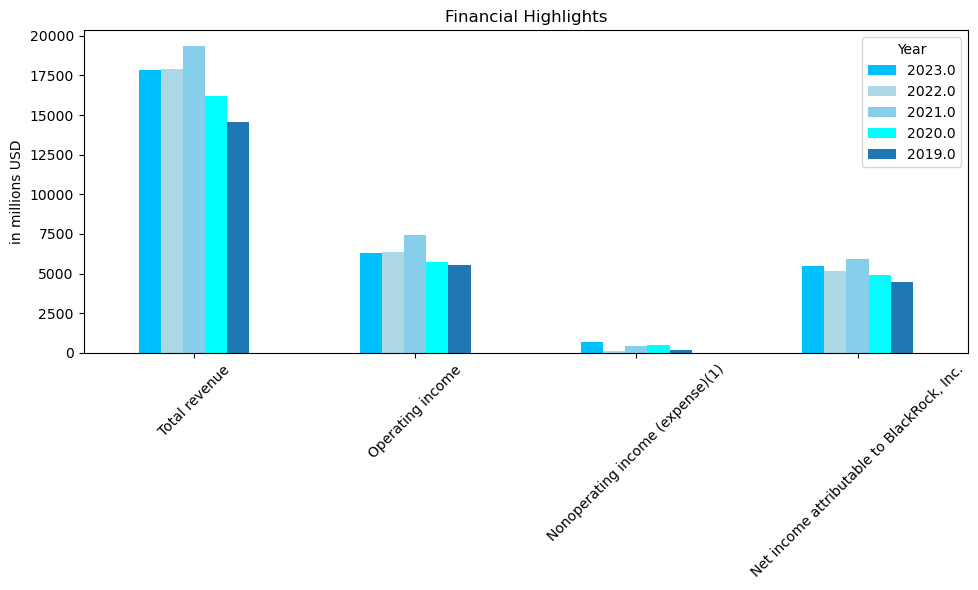

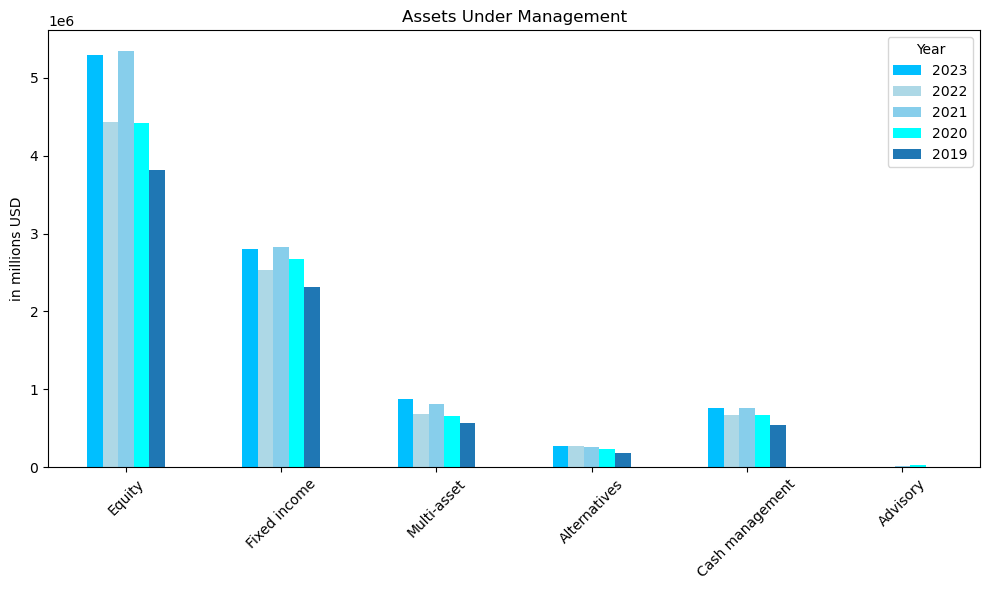

In [260]:
for table in (0,2):
    df = table_list[table]
    df.set_index(df.columns[0], inplace=True)
    if table == 0:
        df = df.drop(['Operating margin','Diluted earnings per common share'], axis = 0)
    if table == 2:    
        df = df.drop(['Long-term','Total'], axis = 0)
        df = df.iloc[:,:-1]
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
    df.plot(kind = 'bar', figsize=(10, 6), color = ['deepskyblue', 'lightblue', 'skyblue','aqua', '#1f77b4'])
    if table == 0:
        plt.title('Financial Highlights')
    if table == 2:
        plt.title('Assets Under Management')
    plt.xlabel('')
    plt.ylabel('in millions USD')
    plt.xticks(rotation = 45)
    plt.legend(title = 'Year')
    plt.tight_layout()
    plt.show()